In [1]:
import tensorflow as tf
import numpy as np
from scipy.io import loadmat, savemat
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from time import time
%matplotlib notebook

In [2]:
path = "C:/Users/ameyc/Documents/deep-learning-microscopes/malaria/data/positive_cropped.mat"
mal_dict = loadmat(path)
infected = mal_dict['stack']
path = "C:/Users/ameyc/Documents/deep-learning-microscopes/malaria/data/negative_cropped.mat"
wmal_dict = loadmat(path)
normal = wmal_dict['stack']
infected = np.moveaxis(infected, -1, 0)
normal = np.moveaxis(normal, -1, 0)

infected_train, infected_test = train_test_split(infected, test_size = 0.2)
normal_train, normal_test = train_test_split(normal, test_size = 0.2)
data = (infected_train, infected_test, normal_train, normal_test)

In [3]:
add_noise = True
pixel_well_depth = 20000
batch_size = 32
numcategories = 2
image_dim = 28
numchannel = 1

In [4]:
def to_one_hot(y,numcategories = 2):
    y_ = np.zeros((y.size,numcategories))
    y_[np.arange(y.size),y]=1
    return y_

In [5]:
def get_feed_dict_superposition(data, n = 0, training=True):
    # data is the output of load_data_malaria
    # n+1 is the number of images summed, where one is malaria-infected
    # intensity_scale: tune this value so that the detector doesn't saturate
    # training specifies whether to generate from the training data or validation data
    # returns a feed_dict for training (or validation)
    intensity_scale = 1/(n+1)
    X1train, X1val, X0train, X0val = data
    
    if training:
        X0 = X0train
        X1 = X1train
        X0 = np.mean(X0, 3)[:, :, :, None]  # keep color channel for CNN
        X1 = np.mean(X1, 3)[:, :, :, None]
    else:
        X0 = X0val
        X1 = X1val
        X0 = np.mean(X0, 3)[:, :, :, None]  # keep color channel for CNN
        X1 = np.mean(X1, 3)[:, :, :, None]
    
    s0 = X0.shape
    s1 = X1.shape
    
    # make half of the batch no malaria, half with malaria
    inds0 = np.random.choice(s0[0],size=batch_size*(n+1)-batch_size//2) #for the non-malaria
    inds1 = np.random.choice(s1[0],size=batch_size//2) #for the malaria; only 1 malaria per stack; for half of the batch
    
    # examples for no malaria in stack
    X0stack = X0[inds0[:batch_size//2*(n+1)]].reshape(batch_size//2,n+1,s0[1],s0[2],s0[3])
    X0stack = X0stack.sum(1) #the superpositioned image
    
    # examples for one malaria in stack
    X1stack0 = X0[inds0[batch_size//2*(n+1):]].reshape(batch_size//2,n,s0[1],s0[2],s0[3]) #from the nonmalaria set
    X1stack1 = X1[inds1]
    X1stack = X1stack0.sum(1) + X1stack1
    
    # stack them all together
    Xbatch = np.concatenate([X0stack,X1stack],axis=0)*intensity_scale
    if add_noise:
        Xbatch += np.random.normal(loc=0, scale=np.sqrt(Xbatch*(1-1/(n+1)/numchannel)*256/pixel_well_depth))
    Xbatch = np.minimum(Xbatch,255).astype(np.uint8).astype(np.float32) # threshold and discretize to 8-bit
    ybatch = np.concatenate([np.zeros(batch_size//2,dtype=np.int32),np.ones(batch_size//2,dtype=np.int32)])
    ybatch = to_one_hot(ybatch)
    
    return {X:Xbatch, y:ybatch}

In [6]:
def pass_through_validation(rawdata, n, sess, numbatches, use_random_seed=True):
    #there's no longer a fixed validation set: generate on the fly
    if use_random_seed:
        np.random.seed(0)
    acc = 0
    for i in range(numbatches):
        feed = get_feed_dict_superposition(rawdata, n=n, training=False)
        acc += sess.run(accuracy, feed_dict=feed)
    return acc/numbatches

In [7]:
def CNN2(net,labels,numcategories=10):
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.Flatten()(net) #flatten for fc
    net = tf.layers.dense(net,1024)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.dense(net,numcategories)
    return net #return net to examine accuracy

In [8]:
acc = list()
fulls = time()
for n in range(15):
    tf.reset_default_graph() 
    sess = tf.Session()
    X = tf.placeholder(dtype=tf.float32, name='data', shape=(batch_size, image_dim, image_dim, numchannel))
    y = tf.placeholder(dtype=tf.int32, name='labels', shape=(batch_size, numcategories))
    pred = CNN2(X, y, 2)  # add batch dim
    loss = tf.losses.softmax_cross_entropy(logits=pred, onehot_labels=y)
    train_op = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)
    prediction = tf.argmax(pred,1)
    truth = tf.argmax(y,1)
    accuracy = tf.reduce_mean(tf.to_float(tf.equal(prediction,truth)))
    
    Accuracy = list()
    for runs in range (10):
        sess.run(tf.global_variables_initializer())
        train_losses = list()
        val_losses = list()
        start=time()
        for i in range(251):
            feed = get_feed_dict_superposition(data, n = n, training = True)
            _, tloss = sess.run([train_op, loss], feed_dict = feed)
            train_losses.append(tloss)
            if i%50==0:
                val_losses.append(pass_through_validation(data, n, sess, numbatches=30))
                print("iteration %d; batch classifier loss: %f; batch Validation accuracy: %f; Time passed in this loop: %.2f" % 
                      (i,train_losses[-1],val_losses[-1],time()-start))
        Accuracy.append(val_losses[-1])
    acc.append(Accuracy)
    sess.close()
fulle = time()

iteration 0; batch classifier loss: 0.935254; batch Validation accuracy: 0.500000; Time passed in this loop: 3.40
iteration 50; batch classifier loss: 0.010521; batch Validation accuracy: 0.970833; Time passed in this loop: 4.89
iteration 100; batch classifier loss: 0.010930; batch Validation accuracy: 0.970833; Time passed in this loop: 6.40
iteration 150; batch classifier loss: 0.011098; batch Validation accuracy: 0.966667; Time passed in this loop: 7.89
iteration 200; batch classifier loss: 0.009331; batch Validation accuracy: 0.967708; Time passed in this loop: 9.39
iteration 250; batch classifier loss: 0.010813; batch Validation accuracy: 0.971875; Time passed in this loop: 10.89
iteration 0; batch classifier loss: 0.834606; batch Validation accuracy: 0.500000; Time passed in this loop: 0.23
iteration 50; batch classifier loss: 0.010946; batch Validation accuracy: 0.970833; Time passed in this loop: 1.72
iteration 100; batch classifier loss: 0.009034; batch Validation accuracy: 0.

iteration 250; batch classifier loss: 0.257544; batch Validation accuracy: 0.944792; Time passed in this loop: 7.92
iteration 0; batch classifier loss: 0.682772; batch Validation accuracy: 0.500000; Time passed in this loop: 0.25
iteration 50; batch classifier loss: 0.286455; batch Validation accuracy: 0.931250; Time passed in this loop: 1.75
iteration 100; batch classifier loss: 0.283544; batch Validation accuracy: 0.937500; Time passed in this loop: 3.25
iteration 150; batch classifier loss: 0.319122; batch Validation accuracy: 0.933333; Time passed in this loop: 4.75
iteration 200; batch classifier loss: 0.273245; batch Validation accuracy: 0.940625; Time passed in this loop: 6.23
iteration 250; batch classifier loss: 0.261075; batch Validation accuracy: 0.939583; Time passed in this loop: 7.72
iteration 0; batch classifier loss: 1.637744; batch Validation accuracy: 0.500000; Time passed in this loop: 0.23
iteration 50; batch classifier loss: 0.302395; batch Validation accuracy: 0.9

iteration 200; batch classifier loss: 0.036036; batch Validation accuracy: 0.895833; Time passed in this loop: 6.15
iteration 250; batch classifier loss: 0.049782; batch Validation accuracy: 0.866667; Time passed in this loop: 7.63
iteration 0; batch classifier loss: 0.660702; batch Validation accuracy: 0.500000; Time passed in this loop: 0.23
iteration 50; batch classifier loss: 0.078437; batch Validation accuracy: 0.898958; Time passed in this loop: 1.71
iteration 100; batch classifier loss: 0.064342; batch Validation accuracy: 0.892708; Time passed in this loop: 3.18
iteration 150; batch classifier loss: 0.050563; batch Validation accuracy: 0.907292; Time passed in this loop: 4.66
iteration 200; batch classifier loss: 0.096843; batch Validation accuracy: 0.853125; Time passed in this loop: 6.13
iteration 250; batch classifier loss: 0.043983; batch Validation accuracy: 0.901042; Time passed in this loop: 7.60
iteration 0; batch classifier loss: 0.886270; batch Validation accuracy: 0.

iteration 150; batch classifier loss: 0.166672; batch Validation accuracy: 0.848958; Time passed in this loop: 4.67
iteration 200; batch classifier loss: 0.160915; batch Validation accuracy: 0.848958; Time passed in this loop: 6.15
iteration 250; batch classifier loss: 0.153362; batch Validation accuracy: 0.850000; Time passed in this loop: 7.64
iteration 0; batch classifier loss: 0.811285; batch Validation accuracy: 0.500000; Time passed in this loop: 0.24
iteration 50; batch classifier loss: 0.233567; batch Validation accuracy: 0.862500; Time passed in this loop: 1.71
iteration 100; batch classifier loss: 0.185995; batch Validation accuracy: 0.852083; Time passed in this loop: 3.20
iteration 150; batch classifier loss: 0.163571; batch Validation accuracy: 0.875000; Time passed in this loop: 4.67
iteration 200; batch classifier loss: 0.175231; batch Validation accuracy: 0.863542; Time passed in this loop: 6.17
iteration 250; batch classifier loss: 0.179194; batch Validation accuracy: 

iteration 100; batch classifier loss: 0.401093; batch Validation accuracy: 0.843750; Time passed in this loop: 3.28
iteration 150; batch classifier loss: 0.398563; batch Validation accuracy: 0.840625; Time passed in this loop: 4.83
iteration 200; batch classifier loss: 0.402884; batch Validation accuracy: 0.840625; Time passed in this loop: 6.37
iteration 250; batch classifier loss: 0.401153; batch Validation accuracy: 0.838542; Time passed in this loop: 7.89
iteration 0; batch classifier loss: 0.805962; batch Validation accuracy: 0.500000; Time passed in this loop: 0.24
iteration 50; batch classifier loss: 0.392740; batch Validation accuracy: 0.843750; Time passed in this loop: 1.75
iteration 100; batch classifier loss: 0.377394; batch Validation accuracy: 0.831250; Time passed in this loop: 3.27
iteration 150; batch classifier loss: 0.383281; batch Validation accuracy: 0.844792; Time passed in this loop: 4.78
iteration 200; batch classifier loss: 0.390915; batch Validation accuracy: 

iteration 50; batch classifier loss: 0.473267; batch Validation accuracy: 0.785417; Time passed in this loop: 1.77
iteration 100; batch classifier loss: 0.312795; batch Validation accuracy: 0.785417; Time passed in this loop: 3.52
iteration 150; batch classifier loss: 0.290015; batch Validation accuracy: 0.769792; Time passed in this loop: 5.22
iteration 200; batch classifier loss: 0.280589; batch Validation accuracy: 0.777083; Time passed in this loop: 6.81
iteration 250; batch classifier loss: 0.278626; batch Validation accuracy: 0.775000; Time passed in this loop: 8.44
iteration 0; batch classifier loss: 0.687222; batch Validation accuracy: 0.500000; Time passed in this loop: 0.56
iteration 50; batch classifier loss: 0.571735; batch Validation accuracy: 0.643750; Time passed in this loop: 2.30
iteration 100; batch classifier loss: 0.506164; batch Validation accuracy: 0.798958; Time passed in this loop: 3.96
iteration 150; batch classifier loss: 0.564521; batch Validation accuracy: 0

iteration 0; batch classifier loss: 0.861031; batch Validation accuracy: 0.500000; Time passed in this loop: 0.24
iteration 50; batch classifier loss: 0.536430; batch Validation accuracy: 0.777083; Time passed in this loop: 1.82
iteration 100; batch classifier loss: 0.404463; batch Validation accuracy: 0.750000; Time passed in this loop: 3.38
iteration 150; batch classifier loss: 0.383185; batch Validation accuracy: 0.797917; Time passed in this loop: 4.93
iteration 200; batch classifier loss: 0.403762; batch Validation accuracy: 0.797917; Time passed in this loop: 6.53
iteration 250; batch classifier loss: 0.446113; batch Validation accuracy: 0.766667; Time passed in this loop: 8.25
iteration 0; batch classifier loss: 0.743359; batch Validation accuracy: 0.500000; Time passed in this loop: 0.26
iteration 50; batch classifier loss: 0.602848; batch Validation accuracy: 0.672917; Time passed in this loop: 1.81
iteration 100; batch classifier loss: 0.445394; batch Validation accuracy: 0.7

iteration 250; batch classifier loss: 0.394892; batch Validation accuracy: 0.789583; Time passed in this loop: 7.75
iteration 0; batch classifier loss: 2.542765; batch Validation accuracy: 0.500000; Time passed in this loop: 0.24
iteration 50; batch classifier loss: 0.604823; batch Validation accuracy: 0.776042; Time passed in this loop: 1.74
iteration 100; batch classifier loss: 0.685453; batch Validation accuracy: 0.776042; Time passed in this loop: 3.24
iteration 150; batch classifier loss: 0.615902; batch Validation accuracy: 0.746875; Time passed in this loop: 4.74
iteration 200; batch classifier loss: 0.410851; batch Validation accuracy: 0.785417; Time passed in this loop: 6.23
iteration 250; batch classifier loss: 0.407628; batch Validation accuracy: 0.783333; Time passed in this loop: 7.74
iteration 0; batch classifier loss: 1.394431; batch Validation accuracy: 0.500000; Time passed in this loop: 0.24
iteration 50; batch classifier loss: 0.589887; batch Validation accuracy: 0.5

iteration 200; batch classifier loss: 0.627708; batch Validation accuracy: 0.594792; Time passed in this loop: 6.25
iteration 250; batch classifier loss: 0.579644; batch Validation accuracy: 0.617708; Time passed in this loop: 7.76
iteration 0; batch classifier loss: 0.825057; batch Validation accuracy: 0.500000; Time passed in this loop: 0.24
iteration 50; batch classifier loss: 0.632051; batch Validation accuracy: 0.752083; Time passed in this loop: 1.75
iteration 100; batch classifier loss: 0.633818; batch Validation accuracy: 0.662500; Time passed in this loop: 3.27
iteration 150; batch classifier loss: 0.632243; batch Validation accuracy: 0.606250; Time passed in this loop: 4.79
iteration 200; batch classifier loss: 0.617457; batch Validation accuracy: 0.619792; Time passed in this loop: 6.31
iteration 250; batch classifier loss: 0.590523; batch Validation accuracy: 0.625000; Time passed in this loop: 7.81
iteration 0; batch classifier loss: 0.945098; batch Validation accuracy: 0.

iteration 150; batch classifier loss: 0.416432; batch Validation accuracy: 0.754167; Time passed in this loop: 4.89
iteration 200; batch classifier loss: 0.414161; batch Validation accuracy: 0.721875; Time passed in this loop: 6.51
iteration 250; batch classifier loss: 0.514907; batch Validation accuracy: 0.751042; Time passed in this loop: 8.10
iteration 0; batch classifier loss: 1.038504; batch Validation accuracy: 0.500000; Time passed in this loop: 0.27
iteration 50; batch classifier loss: 0.607636; batch Validation accuracy: 0.657292; Time passed in this loop: 1.86
iteration 100; batch classifier loss: 0.492951; batch Validation accuracy: 0.738542; Time passed in this loop: 3.40
iteration 150; batch classifier loss: 0.467475; batch Validation accuracy: 0.746875; Time passed in this loop: 4.95
iteration 200; batch classifier loss: 0.480299; batch Validation accuracy: 0.744792; Time passed in this loop: 6.54
iteration 250; batch classifier loss: 0.465566; batch Validation accuracy: 

iteration 100; batch classifier loss: 0.570682; batch Validation accuracy: 0.683333; Time passed in this loop: 3.51
iteration 150; batch classifier loss: 0.515058; batch Validation accuracy: 0.656250; Time passed in this loop: 5.10
iteration 200; batch classifier loss: 0.496453; batch Validation accuracy: 0.678125; Time passed in this loop: 6.75
iteration 250; batch classifier loss: 0.491772; batch Validation accuracy: 0.664583; Time passed in this loop: 8.34
iteration 0; batch classifier loss: 0.738916; batch Validation accuracy: 0.500000; Time passed in this loop: 0.29
iteration 50; batch classifier loss: 0.564625; batch Validation accuracy: 0.755208; Time passed in this loop: 1.88
iteration 100; batch classifier loss: 0.487970; batch Validation accuracy: 0.690625; Time passed in this loop: 3.49
iteration 150; batch classifier loss: 0.480276; batch Validation accuracy: 0.685417; Time passed in this loop: 5.08
iteration 200; batch classifier loss: 0.485962; batch Validation accuracy: 

iteration 50; batch classifier loss: 0.683068; batch Validation accuracy: 0.689583; Time passed in this loop: 2.09
iteration 100; batch classifier loss: 0.644649; batch Validation accuracy: 0.718750; Time passed in this loop: 3.69
iteration 150; batch classifier loss: 0.587242; batch Validation accuracy: 0.712500; Time passed in this loop: 5.28
iteration 200; batch classifier loss: 0.583110; batch Validation accuracy: 0.744792; Time passed in this loop: 6.88
iteration 250; batch classifier loss: 0.573956; batch Validation accuracy: 0.717708; Time passed in this loop: 8.51
iteration 0; batch classifier loss: 1.103529; batch Validation accuracy: 0.500000; Time passed in this loop: 0.28
iteration 50; batch classifier loss: 0.678256; batch Validation accuracy: 0.556250; Time passed in this loop: 1.90
iteration 100; batch classifier loss: 0.633545; batch Validation accuracy: 0.734375; Time passed in this loop: 3.49
iteration 150; batch classifier loss: 0.570875; batch Validation accuracy: 0

iteration 0; batch classifier loss: 0.716746; batch Validation accuracy: 0.500000; Time passed in this loop: 0.28
iteration 50; batch classifier loss: 0.692334; batch Validation accuracy: 0.519792; Time passed in this loop: 1.92
iteration 100; batch classifier loss: 0.638720; batch Validation accuracy: 0.728125; Time passed in this loop: 3.56
iteration 150; batch classifier loss: 0.590488; batch Validation accuracy: 0.723958; Time passed in this loop: 5.22
iteration 200; batch classifier loss: 0.561894; batch Validation accuracy: 0.734375; Time passed in this loop: 6.87
iteration 250; batch classifier loss: 0.544871; batch Validation accuracy: 0.745833; Time passed in this loop: 8.50
iteration 0; batch classifier loss: 1.050246; batch Validation accuracy: 0.500000; Time passed in this loop: 0.30
iteration 50; batch classifier loss: 0.670603; batch Validation accuracy: 0.522917; Time passed in this loop: 1.94
iteration 100; batch classifier loss: 0.636810; batch Validation accuracy: 0.7

In [13]:
acc

[[0.971875,
  0.9708333333333333,
  0.9427083333333334,
  0.9708333333333333,
  0.9520833333333333,
  0.9697916666666667,
  0.9666666666666667,
  0.9520833333333333,
  0.9760416666666667,
  0.9572916666666667],
 [0.946875,
  0.9447916666666667,
  0.9395833333333333,
  0.946875,
  0.9427083333333334,
  0.9552083333333333,
  0.9364583333333333,
  0.946875,
  0.9416666666666667,
  0.9489583333333333],
 [0.8760416666666667,
  0.8604166666666667,
  0.89375,
  0.8666666666666667,
  0.9010416666666666,
  0.8677083333333333,
  0.8770833333333333,
  0.8572916666666667,
  0.8916666666666667,
  0.865625],
 [0.859375,
  0.8614583333333333,
  0.85625,
  0.8458333333333333,
  0.8614583333333333,
  0.85,
  0.8604166666666667,
  0.8520833333333333,
  0.8541666666666666,
  0.8479166666666667],
 [0.8354166666666667,
  0.8395833333333333,
  0.8479166666666667,
  0.8375,
  0.8479166666666667,
  0.84375,
  0.8375,
  0.8385416666666666,
  0.85,
  0.8447916666666667],
 [0.7875,
  0.78125,
  0.763541666666666

In [14]:
fulle-fulls

1268.5392453670502

Text(0, 0.5, 'accuracy')

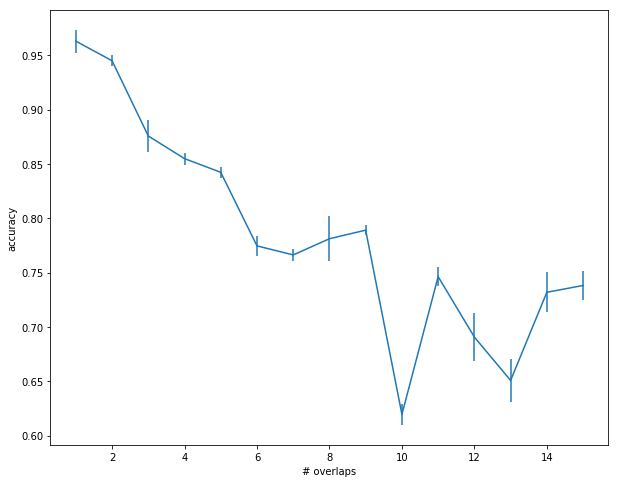

In [15]:
std = np.std(acc, axis=1)
mean = np.mean(acc, axis=1)
plt.figure(figsize=(10,8))
plt.errorbar(np.arange(1,16), mean, yerr=[std, std])
plt.xlabel("# overlaps")
plt.ylabel("accuracy")

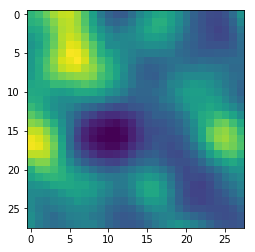

In [12]:
feed = get_feed_dict_superposition(data, n = 0, training = True)
plt.imshow(feed[X][20][:,:,0].astype(np.uint8))